# Santander Customer Transaction Prediction
This notebook refers to my solution to a <a href=https://www.kaggle.com/competitions/santander-customer-transaction-prediction/overview>kaggle competition problem</a>. The following is the competition's description:

"At Santander our mission is to help people and businesses prosper. We are always looking for ways to help our customers understand their financial health and identify which products and services might help them achieve their monetary goals.

Our data science team is continually challenging our machine learning algorithms, working with the global data science community to make sure we can more accurately identify new ways to solve our most common challenge, binary classification problems such as: is a customer satisfied? Will a customer buy this product? Can a customer pay this loan?

In this challenge, we invite Kagglers to help us identify which customers will make a specific transaction in the future, irrespective of the amount of money transacted. The data provided for this competition has the same structure as the real data we have available to solve this problem."

## Imports

In [1]:
%%bash
pip install -q catboost 

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.6/76.6 MB 19.0 MB/s eta 0:00:00


In [2]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split 
from sklearn.metrics import classification_report
from imblearn.over_sampling import ADASYN, SMOTE, BorderlineSMOTE, SVMSMOTE
from imblearn.under_sampling import RandomUnderSampler
import seaborn as sns
from tqdm import tqdm
import matplotlib.pyplot as plt
from google.colab import output
output.enable_custom_widget_manager()
from dataprep.eda import create_report
from catboost import CatBoostClassifier
from google.colab import drive

ModuleNotFoundError: ignored

# Enabling Kaggle API


In [ ]:
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Copying kaggle api key to working directory
!cp drive/MyDrive/Colab\ Notebooks/kaggle.json .

In [ ]:
# Then move kaggle.json into the folder where the API expects to find it.
!mkdir -p ~/.kaggle/ && mv kaggle.json ~/.kaggle/ && chmod 600 ~/.kaggle/kaggle.json

In [ ]:
# Downloading competition data
!kaggle competitions download -c santander-customer-transaction-prediction

santander-customer-transaction-prediction.zip: Skipping, found more recently modified local copy (use --force to force download)


In [ ]:
!unzip santander-customer-transaction-prediction.zip

Archive:  santander-customer-transaction-prediction.zip
replace sample_submission.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: N


# Exploratory Data Analysis

In [ ]:
df = pd.read_csv("train.csv")
df.head()

,ID_code,target,var_0,var_1,var_2,var_3,var_4,var_5,var_6,var_7,...,var_190,var_191,var_192,var_193,var_194,var_195,var_196,var_197,var_198,var_199
0,train_0,0,8.9255,-6.7863,11.9081,5.0930,11.4607,-9.2834,5.1187,18.6266,...,4.4354,3.9642,3.1364,1.6910,18.5227,-2.3978,7.8784,8.5635,12.7803,-1.0914
1,train_1,0,11.5006,-4.1473,13.8588,5.3890,12.3622,7.0433,5.6208,16.5338,...,7.6421,7.7214,2.5837,10.9516,15.4305,2.0339,8.1267,8.7889,18.3560,1.9518
2,train_2,0,8.6093,-2.7457,12.0805,7.8928,10.5825,-9.0837,6.9427,14.6155,...,2.9057,9.7905,1.6704,1.6858,21.6042,3.1417,-6.5213,8.2675,14.7222,0.3965
3,train_3,0,11.0604,-2.1518,8.9522,7.1957,12.5846,-1.8361,5.8428,14.9250,...,4.4666,4.7433,0.7178,1.4214,23.0347,-1.2706,-2.9275,10.2922,17.9697,-8.9996
4,train_4,0,9.8369,-1.4834,12.8746,6.6375,12.2772,2.4486,5.9405,19.2514,...,-1.4905,9.5214,-0.1508,9.1942,13.2876,-1.5121,3.9267,9.5031,17.9974,-8.8104


In [ ]:
df.shape

(200000, 202)

The first thing I observe is that there is a class imbalance in the target variable. Let's keep this in mind for the training step... 🤔

In [ ]:
df.target.value_counts()

0    179902
1     20098
Name: target, dtype: int64

 No empty values  ✅

In [ ]:
df.isna().sum()

ID_code    0
target     0
var_0      0
var_1      0
var_2      0
          ..
var_195    0
var_196    0
var_197    0
var_198    0
var_199    0
Length: 202, dtype: int64

No duplicates in the unique identifiers. ✅

In [ ]:
(df.ID_code.value_counts() > 1).sum()

0

The data is unscaled. We probably will need to scale it before the modeling Stage.

In [ ]:
df.iloc[:,2:].describe()

,var_0,var_1,var_2,var_3,var_4,var_5,var_6,var_7,var_8,var_9,...,var_190,var_191,var_192,var_193,var_194,var_195,var_196,var_197,var_198,var_199
count,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,...,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000
mean,10.679914,-1.627622,10.715192,6.796529,11.078333,-5.065317,5.408949,16.545850,0.284162,7.567236,...,3.234440,7.438408,1.927839,3.331774,17.993784,-0.142088,2.303335,8.908158,15.870720,-3.326537
std,3.040051,4.050044,2.640894,2.043319,1.623150,7.863267,0.866607,3.418076,3.332634,1.235070,...,4.559922,3.023272,1.478423,3.992030,3.135162,1.429372,5.454369,0.921625,3.010945,10.438015
min,0.408400,-15.043400,2.117100,-0.040200,5.074800,-32.562600,2.347300,5.349700,-10.505500,3.970500,...,-14.093300,-2.691700,-3.814500,-11.783400,8.694400,-5.261000,-14.209600,5.960600,6.299300,-38.852800
25%,8.453850,-4.740025,8.722475,5.254075,9.883175,-11.200350,4.767700,13.943800,-2.317800,6.618800,...,-0.058825,5.157400,0.889775,0.584600,15.629800,-1.170700,-1.946925,8.252800,13.829700,-11.208475
50%,10.524750,-1.608050,10.580000,6.825000,11.108250,-4.833150,5.385100,16.456800,0.393700,7.629600,...,3.203600,7.347750,1.901300,3.396350,17.957950,-0.172700,2.408900,8.888200,15.934050,-2.819550
75%,12.758200,1.358625,12.516700,8.324100,12.261125,0.924800,6.003000,19.102900,2.937900,8.584425,...,6.406200,9.512525,2.949500,6.205800,20.396525,0.829600,6.556725,9.593300,18.064725,4.836800
max,20.315000,10.376800,19.353000,13.188300,16.671400,17.251600,8.447700,27.691800,10.151300,11.150600,...,18.440900,16.716500,8.402400,18.281800,27.928800,4.272900,18.321500,12.000400,26.079100,28.500700


Interestingly all variables present weak correlation with the target variable as well as with themselves... 😏

In [ ]:
# let's explore a linear correlation first
linear_corr = df.corr()

In [ ]:
linear_corr.iloc[:,0].sort_values(ascending=False)

target     1.000000
var_6      0.066731
var_110    0.064275
var_53     0.063399
var_26     0.062422
             ...   
var_76    -0.061917
var_146   -0.063644
var_12    -0.069489
var_139   -0.074080
var_81    -0.080917
Name: target, Length: 201, dtype: float64

/usr/local/lib/python3.8/dist-packages/seaborn/matrix.py:654: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


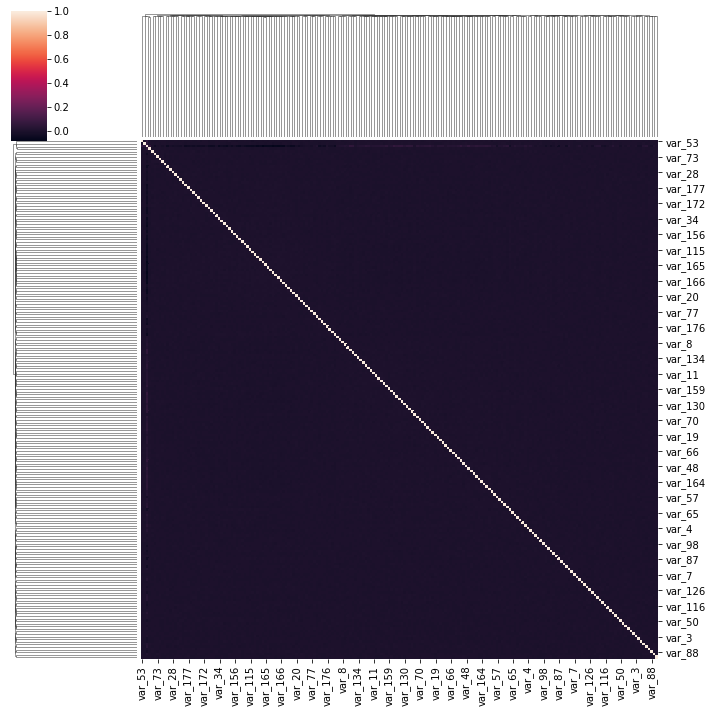

In [ ]:
sns.clustermap(linear_corr)

# checking if the test set follows the same distribution

In [ ]:
test_df = pd.read_csv('test.csv')
test_df.head()

,ID_code,var_0,var_1,var_2,var_3,var_4,var_5,var_6,var_7,var_8,...,var_190,var_191,var_192,var_193,var_194,var_195,var_196,var_197,var_198,var_199
0,test_0,11.0656,7.7798,12.9536,9.4292,11.4327,-2.3805,5.8493,18.2675,2.1337,...,-2.1556,11.8495,-1.4300,2.4508,13.7112,2.4669,4.3654,10.7200,15.4722,-8.7197
1,test_1,8.5304,1.2543,11.3047,5.1858,9.1974,-4.0117,6.0196,18.6316,-4.4131,...,10.6165,8.8349,0.9403,10.1282,15.5765,0.4773,-1.4852,9.8714,19.1293,-20.9760
2,test_2,5.4827,-10.3581,10.1407,7.0479,10.2628,9.8052,4.8950,20.2537,1.5233,...,-0.7484,10.9935,1.9803,2.1800,12.9813,2.1281,-7.1086,7.0618,19.8956,-23.1794
3,test_3,8.5374,-1.3222,12.0220,6.5749,8.8458,3.1744,4.9397,20.5660,3.3755,...,9.5702,9.0766,1.6580,3.5813,15.1874,3.1656,3.9567,9.2295,13.0168,-4.2108
4,test_4,11.7058,-0.1327,14.1295,7.7506,9.1035,-8.5848,6.8595,10.6048,2.9890,...,4.2259,9.1723,1.2835,3.3778,19.5542,-0.2860,-5.1612,7.2882,13.9260,-9.1846


In [ ]:
test_df.describe()

,var_0,var_1,var_2,var_3,var_4,var_5,var_6,var_7,var_8,var_9,...,var_190,var_191,var_192,var_193,var_194,var_195,var_196,var_197,var_198,var_199
count,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,...,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000
mean,10.658737,-1.624244,10.707452,6.788214,11.076399,-5.050558,5.415164,16.529143,0.277135,7.569407,...,3.189766,7.458269,1.925944,3.322016,17.996967,-0.133657,2.290899,8.912428,15.869184,-3.246342
std,3.036716,4.040509,2.633888,2.052724,1.616456,7.869293,0.864686,3.424482,3.333375,1.231865,...,4.551239,3.025189,1.479966,3.995599,3.140652,1.429678,5.446346,0.920904,3.008717,10.398589
min,0.188700,-15.043400,2.355200,-0.022400,5.484400,-27.767000,2.216400,5.713700,-9.956000,4.243300,...,-14.093300,-2.407000,-3.340900,-11.413100,9.382800,-4.911900,-13.944200,6.169600,6.584000,-39.457800
25%,8.442975,-4.700125,8.735600,5.230500,9.891075,-11.201400,4.772600,13.933900,-2.303900,6.623800,...,-0.095000,5.166500,0.882975,0.587600,15.634775,-1.160700,-1.948600,8.260075,13.847275,-11.124000
50%,10.513800,-1.590500,10.560700,6.822350,11.099750,-4.834100,5.391600,16.422700,0.372000,7.632000,...,3.162400,7.379000,1.892600,3.428500,17.977600,-0.162000,2.403600,8.892800,15.943400,-2.725950
75%,12.739600,1.343400,12.495025,8.327600,12.253400,0.942575,6.005800,19.094550,2.930025,8.584825,...,6.336475,9.531100,2.956000,6.174200,20.391725,0.837900,6.519800,9.595900,18.045200,4.935400
max,22.323400,9.385100,18.714100,13.142000,16.037100,17.253700,8.302500,28.292800,9.665500,11.003600,...,20.359000,16.716500,8.005000,17.632600,27.947800,4.545400,15.920700,12.275800,26.538400,27.907400


Since the differences between the train mean,std and test mean,std are so different, we can reliably infer that they come from the same distribution.

In [ ]:
diffs_train_test = np.abs(df.iloc[:,2:].describe() - test_df.describe())
diffs_train_test.head()

,var_0,var_1,var_2,var_3,var_4,var_5,var_6,var_7,var_8,var_9,...,var_190,var_191,var_192,var_193,var_194,var_195,var_196,var_197,var_198,var_199
count,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
mean,0.021177,0.003378,0.007740,0.008315,0.001934,0.014760,0.006215,0.016707,0.007027,0.002171,...,0.044673,0.019861,0.001894,0.009758,0.003183,0.008431,0.012437,0.004270,0.001537,0.080195
std,0.003335,0.009535,0.007006,0.009405,0.006693,0.006026,0.001921,0.006406,0.000741,0.003204,...,0.008683,0.001918,0.001543,0.003568,0.005490,0.000306,0.008024,0.000721,0.002228,0.039426
min,0.219700,0.000000,0.238100,0.017800,0.409600,4.795600,0.130900,0.364000,0.549500,0.272800,...,0.000000,0.284700,0.473600,0.370300,0.688400,0.349100,0.265400,0.209000,0.284700,0.605000
25%,0.010875,0.039900,0.013125,0.023575,0.007900,0.001050,0.004900,0.009900,0.013900,0.005000,...,0.036175,0.009100,0.006800,0.003000,0.004975,0.010000,0.001675,0.007275,0.017575,0.084475


In [ ]:
diffs_train_test.loc['mean'].sort_values(ascending=False)

var_90     0.213171
var_160    0.113119
var_199    0.080195
var_74     0.073592
var_100    0.073495
             ...   
var_93     0.000181
var_23     0.000167
var_183    0.000158
var_30     0.000045
var_68     0.000042
Name: mean, Length: 200, dtype: float64

In [ ]:
diffs_train_test.loc['std'].sort_values(ascending=False)

var_82     0.052982
var_83     0.046642
var_47     0.044858
var_176    0.043062
var_117    0.040849
             ...   
var_25     0.000081
var_100    0.000041
var_12     0.000011
var_68     0.000008
var_161    0.000002
Name: std, Length: 200, dtype: float64

## Scaling Features

In [ ]:
scalers = {}
for col in tqdm(df.columns[2:]):
  scaler = StandardScaler()
  # scaling feature
  df[col] = scaler.fit_transform(df[[col]])
  # appending scaler to scalers dictionary
  scalers[col] = scaler


100%|██████████| 200/200 [00:00<00:00, 202.45it/s]


In [ ]:
df.describe()

,target,var_0,var_1,var_2,var_3,var_4,var_5,var_6,var_7,var_8,...,var_190,var_191,var_192,var_193,var_194,var_195,var_196,var_197,var_198,var_199
count,200000.000000,2.000000e+05,2.000000e+05,2.000000e+05,2.000000e+05,2.000000e+05,2.000000e+05,2.000000e+05,2.000000e+05,2.000000e+05,...,2.000000e+05,2.000000e+05,2.000000e+05,2.000000e+05,2.000000e+05,2.000000e+05,2.000000e+05,2.000000e+05,2.000000e+05,2.000000e+05
mean,0.100490,6.937917e-16,-2.669864e-17,-7.309708e-16,-7.414513e-17,-6.217959e-16,3.385736e-17,-8.895995e-17,6.768275e-16,-4.796163e-18,...,1.096012e-17,2.088285e-16,1.109157e-16,1.251976e-16,-7.932854e-16,4.153122e-17,4.156675e-17,-7.618794e-16,1.381295e-16,3.105072e-17
std,0.300653,1.000003e+00,1.000003e+00,1.000003e+00,1.000003e+00,1.000003e+00,1.000003e+00,1.000003e+00,1.000003e+00,1.000003e+00,...,1.000003e+00,1.000003e+00,1.000003e+00,1.000003e+00,1.000003e+00,1.000003e+00,1.000003e+00,1.000003e+00,1.000003e+00,1.000003e+00
min,0.000000,-3.378739e+00,-3.312510e+00,-3.255758e+00,-3.345903e+00,-3.698703e+00,-3.496937e+00,-3.532923e+00,-3.275579e+00,-3.237586e+00,...,-3.800018e+00,-3.350719e+00,-3.884107e+00,-3.786347e+00,-2.966165e+00,-3.581239e+00,-3.027477e+00,-3.198224e+00,-3.178883e+00,-3.403554e+00
25%,0.000000,-7.322476e-01,-7.684882e-01,-7.545633e-01,-7.548787e-01,-7.363223e-01,-7.802162e-01,-7.399549e-01,-7.612636e-01,-7.807544e-01,...,-7.222214e-01,-7.544853e-01,-7.021442e-01,-6.881662e-01,-7.540249e-01,-7.196264e-01,-7.792415e-01,-7.110907e-01,-6.778686e-01,-7.551204e-01
50%,0.000000,-5.104015e-02,4.832475e-03,-5.119182e-02,1.393366e-02,1.843135e-02,2.952565e-02,-2.751966e-02,-2.605270e-02,3.286843e-02,...,-6.763242e-03,-2.998690e-02,-1.795060e-02,1.617635e-02,-1.142980e-02,-2.141614e-02,1.935421e-02,-2.165493e-02,2.103323e-02,4.857132e-02
75%,0.000000,6.836369e-01,7.373387e-01,6.821601e-01,7.475948e-01,7.287035e-01,7.617868e-01,6.854925e-01,7.480983e-01,7.962906e-01,...,6.955751e-01,6.860521e-01,6.910499e-01,7.199428e-01,7.663868e-01,6.798025e-01,7.798153e-01,7.434083e-01,7.286782e-01,7.820795e-01
max,1.000000,3.169391e+00,2.964030e+00,3.270797e+00,3.128139e+00,3.445820e+00,2.838130e+00,3.506501e+00,3.260893e+00,2.960770e+00,...,3.334816e+00,3.068899e+00,4.379381e+00,3.744977e+00,3.168908e+00,3.088768e+00,2.936766e+00,3.355213e+00,3.390432e+00,3.049173e+00


# Developing base model (Catboost Classifier without data augumentation...)


In [ ]:
df.head()

,ID_code,target,var_0,var_1,var_2,var_3,var_4,var_5,var_6,var_7,...,var_190,var_191,var_192,var_193,var_194,var_195,var_196,var_197,var_198,var_199
0,train_0,0,-0.577102,-1.273737,0.451707,-0.833709,0.235571,-0.536430,-0.334926,0.608751,...,0.263374,-1.149158,0.817469,-0.411013,0.168705,-1.578117,1.022131,-0.373968,-1.026398,0.214135
1,train_1,0,0.269959,-0.622138,1.190360,-0.688846,0.790975,1.539900,0.244461,-0.003525,...,0.966611,0.093605,0.443623,1.908764,-0.817594,1.522342,1.067654,-0.129400,0.825417,0.505685
2,train_2,0,-0.681113,-0.276066,0.516988,0.536516,-0.305477,-0.511033,1.769839,-0.564749,...,-0.072093,0.777997,-0.174131,-0.412316,1.151591,2.297370,-1.617906,-0.695141,-0.381449,0.356681
3,train_3,0,0.125158,-0.129426,-0.667575,0.195355,0.927992,0.410672,0.500633,-0.474201,...,0.270216,-0.891456,-0.818468,-0.478548,1.607869,-0.789517,-0.959020,1.501744,0.697118,-0.543502
4,train_4,0,-0.277303,0.035610,0.817683,-0.077829,0.738607,0.955574,0.613372,0.791544,...,-1.036191,0.688988,-1.405987,1.468536,-1.501101,-0.958473,0.297627,0.645537,0.706318,-0.525375


In [ ]:
X_train, X_val, y_train, y_val = train_test_split(df.iloc[:, 2:],
                                                  df.iloc[:, 1],
                                                  test_size=0.1,
                                                  shuffle=True,
                                                  random_state=2023,
                                                  stratify=df.iloc[:, 1])

# After experimenting with different undersampling and oversampling techniques, I decided Not to use any of these, because they did not yieled good results

In [ ]:
## Applying Oversampling technique
# transform the dataset
#oversample = SMOTE()
#X_train, y_train = oversample.fit_resample(X_train, y_train)
## Applying Undersampling technique
#rus = RandomUnderSampler(random_state=2023)
#X_train, y_train = rus.fit_resample(X_train, y_train)

#print(f"Shape after oversampling: X_train:{X_train.shape} --- y_train: {y_train.shape}")

Shape before undersampling: X_train:(180000, 200) --- y_train: (180000,)
Shape before oversampling: X_train:(36176, 200) --- y_train: (36176,)
Shape after oversampling: X_train:(36176, 200) --- y_train: (36176,)


In [ ]:
cb = CatBoostClassifier(iterations=30000,
                        task_type="GPU",
                        devices='0:1',
                        eval_metric='AUC')

In [ ]:
cb.fit(X_train, y_train,
       logging_level='Verbose',
       eval_set=(X_val, y_val),
       plot=True,
       use_best_model=True)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Learning rate set to 0.011202
0:	test: 0.6309219	best: 0.6309219 (0)	total: 11.2ms	remaining: 5m 35s
1:	total: 19.2ms	remaining: 4m 48s
2:	total: 27.2ms	remaining: 4m 32s
3:	total: 33.5ms	remaining: 4m 10s
4:	total: 39.6ms	remaining: 3m 57s
5:	test: 0.7051924	best: 0.7051924 (5)	total: 47.3ms	remaining: 3m 56s
6:	total: 53.3ms	remaining: 3m 48s
7:	total: 59.2ms	remaining: 3m 41s
8:	total: 65ms	remaining: 3m 36s
9:	total: 71ms	remaining: 3m 32s
10:	test: 0.7229167	best: 0.7229167 (10)	total: 78.6ms	remaining: 3m 34s
11:	total: 84.9ms	remaining: 3m 32s
12:	total: 91.2ms	remaining: 3m 30s
13:	total: 97.3ms	remaining: 3m 28s


Default metric period is 5 because AUC is/are not implemented for GPU


Streaming output truncated to the last 5000 lines.
25003:	total: 2m 23s	remaining: 28.7s
25004:	total: 2m 23s	remaining: 28.7s
25005:	test: 0.9031148	best: 0.9031393 (24485)	total: 2m 23s	remaining: 28.6s
25006:	total: 2m 23s	remaining: 28.6s
25007:	total: 2m 23s	remaining: 28.6s
25008:	total: 2m 23s	remaining: 28.6s
25009:	total: 2m 23s	remaining: 28.6s
25010:	test: 0.9031099	best: 0.9031393 (24485)	total: 2m 23s	remaining: 28.6s
25011:	total: 2m 23s	remaining: 28.6s
25012:	total: 2m 23s	remaining: 28.6s
25013:	total: 2m 23s	remaining: 28.6s
25014:	total: 2m 23s	remaining: 28.6s
25015:	test: 0.9031087	best: 0.9031393 (24485)	total: 2m 23s	remaining: 28.6s
25016:	total: 2m 23s	remaining: 28.6s
25017:	total: 2m 23s	remaining: 28.6s
25018:	total: 2m 23s	remaining: 28.6s
25019:	total: 2m 23s	remaining: 28.6s
25020:	test: 0.9031062	best: 0.9031393 (24485)	total: 2m 23s	remaining: 28.6s
25021:	total: 2m 23s	remaining: 28.6s
25022:	total: 2m 23s	remaining: 28.6s
25023:	total: 2m 23s	remainin

# RESULTS WITHOUT OVERSAMPLING

In [ ]:
y_pred_train = cb.predict(X_train)

In [ ]:
print(classification_report(y_train, y_pred_train))

              precision    recall  f1-score   support

           0       0.97      1.00      0.98    161912
           1       0.99      0.69      0.81     18088

    accuracy                           0.97    180000
   macro avg       0.98      0.85      0.90    180000
weighted avg       0.97      0.97      0.97    180000



In [ ]:
y_pred_val = cb.predict(X_val)
print(classification_report(y_val, y_pred_val))

              precision    recall  f1-score   support

           0       0.93      0.99      0.96     17990
           1       0.78      0.37      0.50      2010

    accuracy                           0.93     20000
   macro avg       0.86      0.68      0.73     20000
weighted avg       0.92      0.93      0.91     20000

